In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from diffcut.ldm import LdmExtractor
from diffcut.segmentor import DiffCut

from tools.pamr import PAMR
from scipy.ndimage import median_filter

In [2]:
def mask_refinement(labels, image):
    masks = torch.cat([1. * (labels == label) for label in torch.unique(labels)], dim=1)
    # num_iter and dilations impact final result
    labels = PAMR(num_iter=30, dilations=[1, 2, 4, 8, 12, 24, 32])(image, masks)

    labels = 1. * torch.argmax(labels, dim=1)
    labels = median_filter(labels.cpu().numpy(), 3).astype(int)

    return labels

#### __Load Diffusion Model__

In [3]:
extractor = LdmExtractor(model_name="SSD-1B", inverse_scheduler=None)

Loading SD model


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SD model loaded


#### __Diffusion Features Extraction__

In [4]:
img_path = "./assets/coco.jpg"

pil_img = Image.open(img_path).convert('RGB')
image = T.ToTensor()(pil_img).unsqueeze(0).to("cuda")
_, _, h, w = image.shape

img_size = 1024 # 2048

resized_image = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
batched_input = {'img': torch.cat([resized_image], dim=0), 'caption': [""]}

# Diffusion Timesteps
t = 50
diffusion_features = extractor(batched_input, guidance_scale=1., n_steps=10, steps=(t,), encode_method="noise")

# Output features from the final self-attention block of the UNet encoder
features = diffusion_features['down_blocks.2.attentions.1.transformer_blocks.3']

#### __Zero-Shot Image Segmentation__

In [5]:
# Hyperparameters
tau = 0.5
alpha = 10

# Recursive Feature Clustering
feats = features.reshape(1, img_size//32, img_size//32, -1).permute(0, 3, 1, 2).to(torch.float32)
feats_norm = F.normalize(feats, dim=1)
diffcut  = DiffCut()

masks = diffcut.generate_masks(feats_norm, tau=tau, mask_size=(h, w), alpha=alpha)
masks = torch.Tensor(masks).to("cuda")

/home/couaironp/zero-shot_segmentation/DiffCut/tools/pamr.py:54: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x_aff = F.conv2d(x_pad, self.kernel, dilation=d)


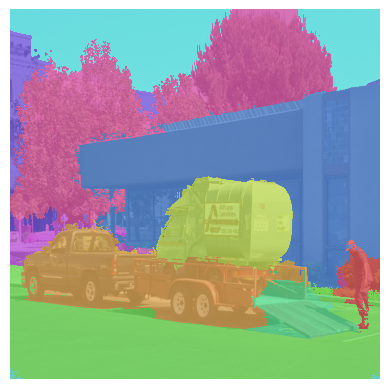

In [6]:
# Mask Refinement
image = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
new_mask = mask_refinement(masks, image)

colors = sns.hls_palette(len(np.unique(new_mask)), h=0.9)
cmap = ListedColormap(colors)

plt.imshow(image.cpu()[0].permute(1, 2, 0))
plt.imshow(new_mask[0], cmap=cmap, interpolation='nearest', alpha=0.8)
plt.axis("off");